## Modeling

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data
df = pd.read_csv('churn_cleaned.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,...,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,1,...,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


From the EDA notebook, a few variables stuck out as interesting and a few looked to be confounding.

In [3]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

I'll trim the columns to have less features to model on.

In [12]:
# define target columns and create a new dataframe
cols = [
    'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
    'MultipleLines', 'InternetService', 'PaymentMethod',
    'MonthlyCharges', 'Churn', 'Contract'
]
dfa = df.loc[:, cols].copy()

# one-hot encode categoricals
encode_cols = ['MultipleLines', 'InternetService', 'PaymentMethod', 'Contract']
df_model = pd.get_dummies(dfa, columns=encode_cols, drop_first=False)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   int64  
 1   Partner                                  7043 non-null   int64  
 2   Dependents                               7043 non-null   int64  
 3   tenure                                   7043 non-null   int64  
 4   MonthlyCharges                           7043 non-null   float64
 5   Churn                                    7043 non-null   int64  
 6   MultipleLines_0                          7043 non-null   bool   
 7   MultipleLines_1                          7043 non-null   bool   
 8   MultipleLines_No phone service           7043 non-null   bool   
 9   InternetService_0                        7043 non-null   bool   
 10  InternetService_DSL                      7043 no

In [32]:
# rename columns with better syntax
df_model = df_model.rename(columns={
    'MultipleLines_No phone service': 'MultipleLines_NoPhoneService',
    'InternetService_Fiber optic': 'InternetService_FiberOptic',
    'PaymentMethod_Credit card (automatic)': 'PaymentMethod_CreditCardAutomatic',
    'PaymentMethod_Electronic check': 'PaymentMethod_ElectronicCheck',
    'PaymentMethod_Mailed check': 'PaymentMethod_MailedCheck',
    'PaymentMethod_Bank transfer (automatic)': 'PaymentMethod_BankTransferAutomatic',
    'Contract_One year':'Contract_One_Year',
    'Contract_Two year':'Contract_Two_Year',
    'Contract_Month-to-month':'Contract_Month_to_Month'
})

# standardize tenure and monthly charges columns
from sklearn.preprocessing import StandardScaler
df_model_scaled = df_model.copy()
num_cols = ['tenure', 'MonthlyCharges']
scaler = StandardScaler()
df_model_scaled[num_cols] = scaler.fit_transform(df_model_scaled[num_cols])

# make boolean columns int64
bool_cols = df_model_scaled.select_dtypes(include=['bool']).columns
df_model_scaled[bool_cols] = df_model_scaled[bool_cols].astype(int)

### Unsupervised Learning
I am going to use PCA to see if my initial hypothesis about two groups holds true.

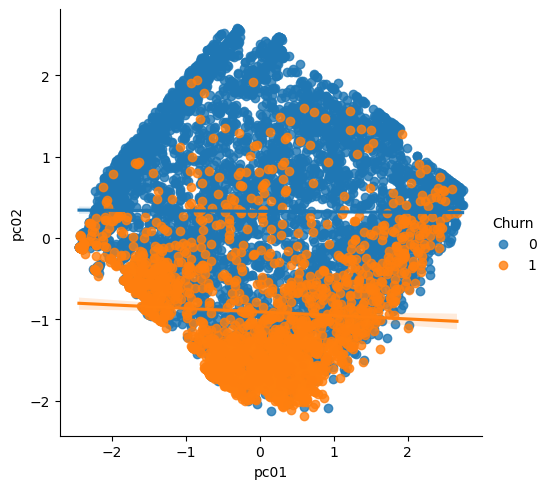

In [35]:
# import modules
from sklearn.decomposition import PCA

# scale numeric variables
X_scaled = df_model_scaled.copy().drop('Churn', axis=1)

# initialize, fit, transform
pca_2 = PCA(n_components=2).fit_transform(X_scaled)

# convert to a dataframe
pca_2_df = pd.DataFrame(pca_2, columns=['pc01', 'pc02'])

# add back target variable
pca_2_df['Churn'] = df_model_scaled['Churn']

# visualize PCA with target variable
sns.lmplot(data=pca_2_df, x='pc01', y='pc02', hue='Churn')
plt.show()

It looks like there are two groupings, although very mixed. This makes sense with a large (7000+) entry dataset, but I want to see how KMeans would look at the PCA results.

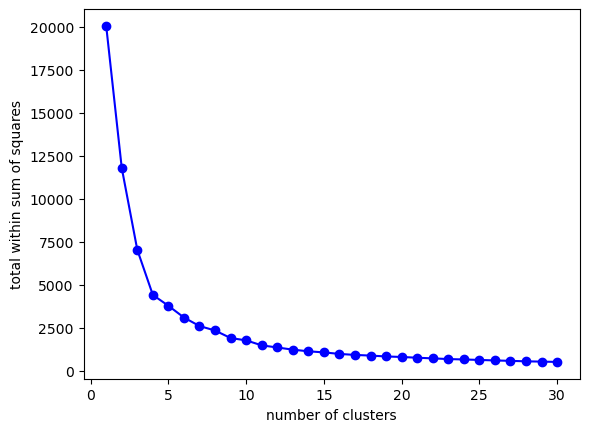

In [38]:
# elbow method

# import modules
from sklearn.cluster import KMeans
from sklearn import cluster

# initialize list
tots_within = []

# generate data
K = range(1,31)
for k in K:
    km = cluster.KMeans(n_clusters=k, random_state=5000,
                        n_init='auto', init='k-means++')
    km = km.fit(pca_2_df[['pc01', 'pc02']])
    tots_within.append(km.inertia_)

# visualize
fig, ax = plt.subplots()
ax.plot(K, tots_within, 'bo-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')
plt.show()

I'll try 3 clusters based on this output.

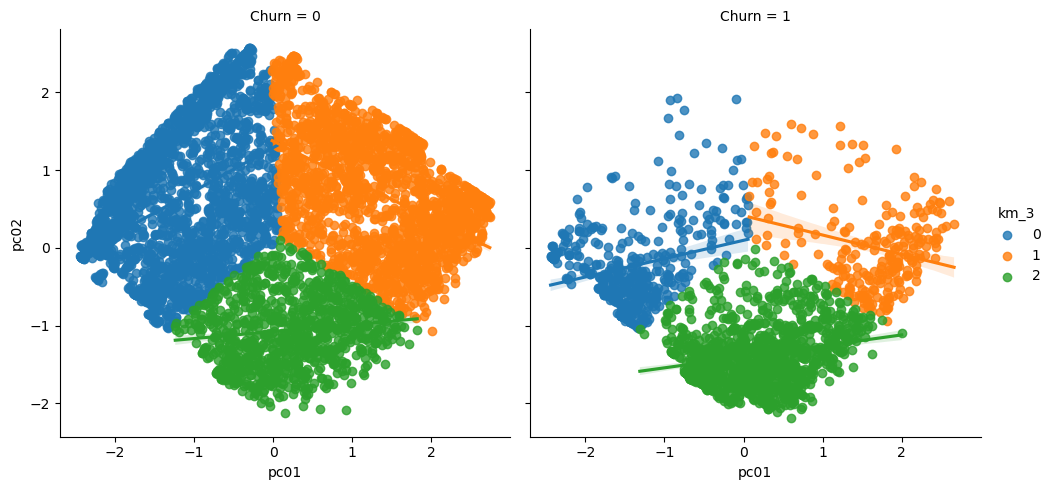

In [41]:
# KMeans

# initialize
k_means = cluster.KMeans(n_clusters=3, init = 'k-means++',\
                         n_init = 'auto', random_state=5000)

# fit
k_means.fit(pca_2_df[['pc01', 'pc02']])

# add back to the dataframe
pca_2_df['km_3'] = k_means.labels_

# visualize PCA with kmeans
sns.lmplot(data=pca_2_df, x='pc01', y='pc02', hue='km_3', col='Churn')
plt.show()

Takeaways
* Unsupervised clustering does not reveal distinct churn segments.
* Churn is not driven by the dominant variance components in the data.
* K-means finds customer archetypes, not churn-risk groups.
* PCA shows those archetypes vary primarily by spending and service mix, not churn.
* Churn sits within each archetype rather than forming its own segment.

### Supervised Learning

#### Simple Linear Regression

In [69]:
# import modules
import statsmodels.formula.api as smf

# fit a linear additive model
model = smf.logit
lm_fit = model(formula='Churn ~ SeniorCitizen + Partner + Dependents + tenure + \
                                    MonthlyCharges + MultipleLines_1 + MultipleLines_NoPhoneService + \
                                    InternetService_DSL + InternetService_FiberOptic + \
                                    PaymentMethod_CreditCardAutomatic + PaymentMethod_ElectronicCheck + PaymentMethod_MailedCheck +\
                                    Contract_Month_to_Month + Contract_One_Year + Contract_Two_Year', 
                 data=df_model_scaled).fit()

Optimization terminated successfully.
         Current function value: 0.421990
         Iterations 10


In [71]:
# define a function to visualize a coefficient plot
def my_coefplot(mod, figsize_use=(10,4)):
    fig, ax = plt.subplots(figsize=figsize_use)
    ax.errorbar(y = mod.params.index,
               x = mod.params,
               xerr = 2 * mod.bse,
               fmt = 'o', color='k', ecolor='k', elinewidth=2, ms=10)
    ax.axvline(x=0, linestyle='--', linewidth=3.5, color='grey')
    ax.set_xlabel('coefficient value')
    plt.show()

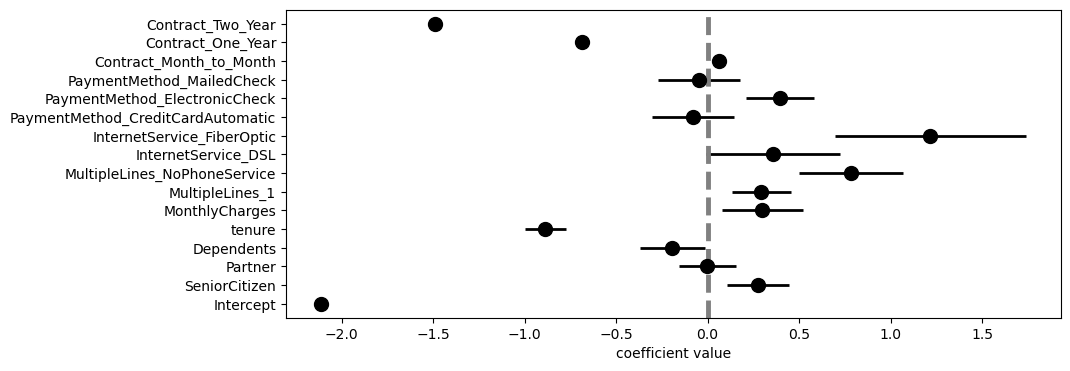

In [73]:
my_coefplot(lm_fit)

In [51]:
lm_results_df = pd.DataFrame(data=lm_fit.params)
lm_results_df.sort_values(by=0)

,0
Intercept,-2.111928
Contract_Two_Year,-1.489051
tenure,-0.886416
Contract_One_Year,-0.684623
Dependents,-0.193861
PaymentMethod_CreditCardAutomatic,-0.080136
PaymentMethod_MailedCheck,-0.047750
Partner,-0.001155
Contract_Month_to_Month,0.061747
SeniorCitizen,0.274529


#### Takeaways
Confidently ***NEGATIVE*** coefficients:
Longer tenure customers with dependents (e.g. families) on long-term contracts churn less. 

Confidently ***POSITIVE*** coefficients:
Senior citizens paying by electronic check with high monthly charges including fiber optic internet, DSL internet, having phone service.

In [55]:
# predicted probabilities
probs = lm_fit.predict()

# ROC-AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(df_model_scaled['Churn'], probs)

print("ROC-AUC:", auc)

ROC-AUC: 0.8402489564338134


In [75]:
# check for multicolinearity

# import modules
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# build design matrix (exclude target)
X = df_model_scaled[[
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'tenure',
    'MonthlyCharges',
    'MultipleLines_1',
    'MultipleLines_NoPhoneService',
    'InternetService_DSL',
    'InternetService_FiberOptic',
    'PaymentMethod_CreditCardAutomatic',
    'PaymentMethod_ElectronicCheck',
    'PaymentMethod_MailedCheck',
    'Contract_One_Year',
    'Contract_Two_Year',
    'Contract_Month_to_Month'
]]

# add const for statsmodels
X_with_const = sm.add_constant(X)

# compute VIF for each column
vif_df = pd.DataFrame({
    'variable': X_with_const.columns,
    'VIF': [variance_inflation_factor(X_with_const.values, i)
            for i in range(X_with_const.shape[1])]
})

vif_df.sort_values(by='VIF')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variable,VIF
0,const,0.000000
1,SeniorCitizen,1.144521
3,Dependents,1.380216
2,Partner,1.459926
6,MultipleLines_1,1.538869
10,PaymentMethod_CreditCardAutomatic,1.559238
7,MultipleLines_NoPhoneService,1.770956
12,PaymentMethod_MailedCheck,1.833917
11,PaymentMethod_ElectronicCheck,1.948888
4,tenure,2.676272


Internet Service DSL, Monthly Charges, and Internet Service Fiber Optic all have VIF vlaues over 5, which may signal multicolinearity.

The two internet services could collide with customer behaviors like billing method and paperless billing, and likely influence monthly charges.

Contract types have an inf VIF score, so I'll remove those to see how the model changes too.

I am going to rerun the model without Monthly Charges to see if the coefficents stay stable.

Optimization terminated successfully.
         Current function value: 0.430268
         Iterations 7


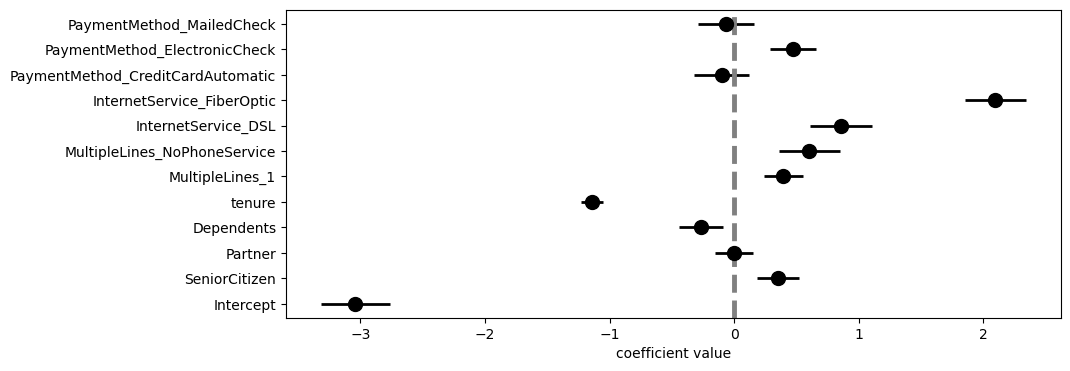

In [77]:
# fit
model2 = smf.logit
lm_fit2 = model2(formula='Churn ~ SeniorCitizen + Partner + Dependents + tenure + \
                                    MultipleLines_1 + MultipleLines_NoPhoneService + \
                                    InternetService_DSL + InternetService_FiberOptic + \
                                    PaymentMethod_CreditCardAutomatic + PaymentMethod_ElectronicCheck + PaymentMethod_MailedCheck', 
                 data=df_model_scaled).fit()

# plot coefficients
my_coefplot(lm_fit2)

In [79]:
# predicted probabilities
probs = lm_fit2.predict()

# ROC-AUC
from sklearn.metrics import roc_auc_score
auc2 = roc_auc_score(df_model_scaled['Churn'], probs)

print("ROC-AUC - Model 1:", auc)
print("ROC-AUC - Model 2:", auc2)

ROC-AUC - Model 1: 0.8402489564338134
ROC-AUC - Model 2: 0.8320199176729016


In [83]:
# check for multicolinearity

# import modules
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# build design matrix (exclude target)
X = df_model_scaled[[
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'tenure',
    'MultipleLines_1',
    'MultipleLines_NoPhoneService',
    'InternetService_DSL',
    'InternetService_FiberOptic',
    'PaymentMethod_CreditCardAutomatic',
    'PaymentMethod_ElectronicCheck',
    'PaymentMethod_MailedCheck'
]]

# add const for statsmodels
X_with_const = sm.add_constant(X)

# compute VIF for each column
vif_df = pd.DataFrame({
    'variable': X_with_const.columns,
    'VIF': [variance_inflation_factor(X_with_const.values, i)
            for i in range(X_with_const.shape[1])]
})

vif_df.sort_values(by='VIF')

,variable,VIF
1,SeniorCitizen,1.135805
6,MultipleLines_NoPhoneService,1.342480
3,Dependents,1.371878
5,MultipleLines_1,1.406568
2,Partner,1.459327
4,tenure,1.492354
9,PaymentMethod_CreditCardAutomatic,1.557978
11,PaymentMethod_MailedCheck,1.833188
10,PaymentMethod_ElectronicCheck,1.932463
7,InternetService_DSL,2.072143


Multicolinearity values dropepd but so did model performance (AUC score).

Moving on to a more advanced Random Forest model.

In [86]:
# import modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# features and target
X = df_model_scaled.drop(axis=1, columns=['Churn', 'MultipleLines_0'])
y = df_model_scaled['Churn']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# model
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# fit
rf.fit(X_train, y_train)

# predict
probs = rf.predict_proba(X_test)[:, 1]
preds = rf.predict(X_test)

# scores
auc = roc_auc_score(y_test, probs)
print("ROC-AUC:", auc)
print(classification_report(y_test, preds))

ROC-AUC: 0.8096192100028416
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.50      0.54       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



The AUC is worse than the simple additive model and the performance on class 1 is very poor. This could be because there are far more retained customers than churners, causing a notable class imbalance, diriving down recall.

I'll try a tuning block to see which parameters to adjust and how.

In [108]:
# import modules
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# define a param grid
param_grid = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced", "balanced_subsample"]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'class_weight': None}
0.8402889805872436


Even with the parameters tuned, the random forest still performs only as well as the simple additive model.

This could be because variables like tenure and internet service type are much stronger than the other variables, causing relationships to be more linear.

Let's try XGBoost.

In [92]:
# install xgboost
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# features and target
X = df_model_scaled.drop(axis=1, columns=['Churn', 'MultipleLines_0'])
y = df_model_scaled['Churn']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# model
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
)

# fit
xgb.fit(X_train, y_train)

# predict
probs = xgb.predict_proba(X_test)[:, 1]
preds = xgb.predict(X_test)

# scores
auc = roc_auc_score(y_test, probs)
print("ROC-AUC:", auc)

print(classification_report(y_test, preds))

ROC-AUC: 0.8320016016946964
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1035
           1       0.51      0.76      0.61       374

    accuracy                           0.75      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409



Precision for the retained group rose while recall fell. Group 1 (churners) had the opposite result, seeing their recall shoot up almost 0.25. Overall model performance seems to have improved because of the nature of the XGBoost classifier. 

### Interpretation
Using SHAP to look at the XGBoost model to determine feature contribution.

In [95]:
# import module
import shap

# shap init
shap.initjs()

# explainer
explainer = shap.TreeExplainer(xgb)

# shap values
shap_vals = explainer.shap_values(X_test)

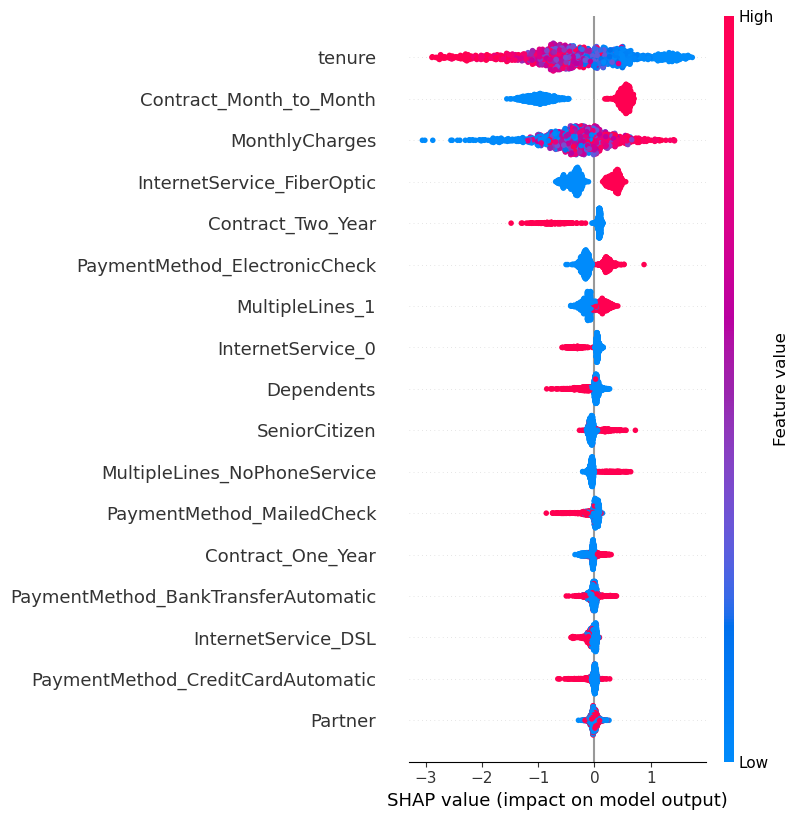

In [97]:
# summary plot (global importance)
shap.summary_plot(shap_vals, X_test)

In [99]:
# single prediction force plot
i = 0
shap.force_plot(explainer.expected_value, shap_vals[i], X_test.iloc[i])

#### Takeaways
* When looking at the SHAP summary plot, tenure is the most important global predictor for retention. Two risk factors for churn based on the summary plot would be payment by electronic check and having fiber optic internet.
* Looking at one customer with the force plot, we see how they have a strong prediction of no churn based on the blut indicators pushing so far left of the base value.

Overall, the strongest driver of churn is low tenure, having fiber optic internet, and payment via electronic check. Other contributors to churn include paperless billing and monthly charges. The strongest driver of retention is long tenure with supporting contributors being having dependents and automatic credit card payments.

#### Feature interactions
Next, let's look at how features in the model interact with each other to see how they can effect results.

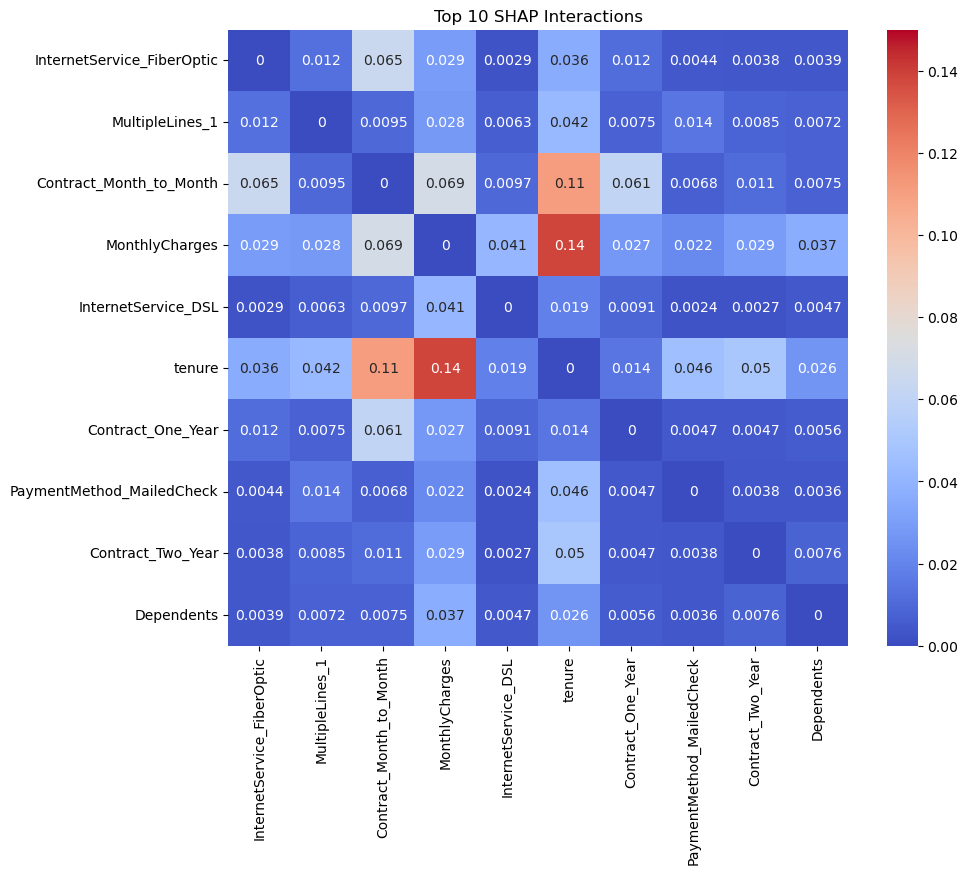

In [122]:
# initialize
shap.initjs()

explainer = shap.TreeExplainer(xgb)

# compute interaction SHAP values
shap_inter = explainer.shap_interaction_values(X_test)

# mean |interaction| across all samples
mean_inter = np.abs(shap_inter).mean(axis=0)

# put into DataFrame for easier handling
inter_df = pd.DataFrame(
    mean_inter,
    index=X_test.columns,
    columns=X_test.columns
)

# remove self interactions by masking diagonal
np.fill_diagonal(mean_inter, 0)

# flatten into long format
pairs = []
cols = X_test.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):   # avoid duplicates
        pairs.append((cols[i], cols[j], mean_inter[i, j]))

# convert to DataFrame and sort
pairs_df = pd.DataFrame(pairs, columns=['feat1', 'feat2', 'interaction'])
top10 = pairs_df.sort_values('interaction', ascending=False).head(10)

# prepare matrix for heatmap
hm_feats = list(set(top10['feat1']).union(set(top10['feat2'])))
hm_matrix = inter_df.loc[hm_feats, hm_feats]

plt.figure(figsize=(10, 8))
sns.heatmap(hm_matrix, annot=True, cmap='coolwarm',
           vmin=0, vmax=0.15)
plt.title("Top 10 SHAP Interactions")
plt.show()

Based on the feature interactions, the best combination predictor of churn is high monthly charges and low tenure.

To a lesser extent, higher monthly charges for DSL customers also predicts churn.

An interesting interaction is tenure and electronic check. This shows that customers may be more likely to churn when they are low tenure and having to approve e-checks to pay their bills. Electronic checks also saw a higher than average interaction with monthly charges for churn. This would imply that new/trial customers with high monthly charges who have to approve e-checks for their bills are more likely to churn since they are seeing the prices every month.

In [114]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "auc": roc_auc_score(y_test, y_prob),
        "acc": accuracy_score(y_test, y_pred),
        "prec1": precision_score(y_test, y_pred, pos_label=1),
        "rec1": recall_score(y_test, y_pred, pos_label=1),
        "f1_1": f1_score(y_test, y_pred, pos_label=1)
    }


# logistic (statsmodels)
logit_probs = lm_fit.predict()
logit_pred = (logit_probs > 0.5).astype(int)

logit_metrics = {
    "auc": roc_auc_score(y, logit_probs),
    "acc": accuracy_score(y, logit_pred),
    "prec1": precision_score(y, logit_pred, pos_label=1),
    "rec1": recall_score(y, logit_pred, pos_label=1),
    "f1_1": f1_score(y, logit_pred, pos_label=1)
}

# untuned random forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_metrics = get_metrics(rf, X_test, y_test)

# tuned random forest
rf_tuned = search.best_estimator_
rf_tuned_metrics = get_metrics(rf_tuned, X_test, y_test)

# XGBoost
xgb_metrics = get_metrics(xgb, X_test, y_test)

# building comparison df
comparison_df = pd.DataFrame([
    ["Logistic Regression", logit_metrics["auc"], logit_metrics["acc"],
     logit_metrics["prec1"], logit_metrics["rec1"], logit_metrics["f1_1"]],

    ["Random Forest", rf_metrics["auc"], rf_metrics["acc"],
     rf_metrics["prec1"], rf_metrics["rec1"], rf_metrics["f1_1"]],

    ["Random Forest (Tuned)", rf_tuned_metrics["auc"], rf_tuned_metrics["acc"],
     rf_tuned_metrics["prec1"], rf_tuned_metrics["rec1"], rf_tuned_metrics["f1_1"]],

    ["XGBoost", xgb_metrics["auc"], xgb_metrics["acc"],
     xgb_metrics["prec1"], xgb_metrics["rec1"], xgb_metrics["f1_1"]]
], columns=["Model","ROC-AUC","Accuracy","Precision(1)","Recall(1)","F1(1)"])

comparison_df

,Model,ROC-AUC,Accuracy,Precision(1),Recall(1),F1(1)
0,Logistic Regression,0.840249,0.800227,0.650391,0.534510,0.586784
1,Random Forest,0.809619,0.775018,0.589342,0.502674,0.542569
2,Random Forest (Tuned),0.843610,0.805536,0.674825,0.516043,0.584848
3,XGBoost,0.832002,0.745209,0.513562,0.759358,0.612729


The tuned random forest has the highest ROC-AUC and accuracy. Logistic regression is close behind with similar discrimination performance. If recall is prioritized over accuracy and precision, XGBoost is useful because it detects more churners, but it gives up about 5.5% accuracy and roughly 17% precision to do so.